
# Fake News Detection: DistilBERT vs MobileBERT Comparison
### This notebook compares the performance of DistilBERT and MobileBERT models for fake news detection using trained models.

## 1. Setup and Installation

In [1]:
import torch
import torch.nn as nn
from transformers import (
    DistilBertForSequenceClassification, 
    DistilBertTokenizer,
    MobileBertForSequenceClassification, 
    MobileBertTokenizer
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split
import time
import os
import sys
from tqdm.auto import tqdm
import warnings
import json
import pickle
from pathlib import Path
warnings.filterwarnings('ignore')

# Add parent directory to path for custom modules
sys.path.append('..')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"GPU available: {torch.cuda.is_available()}")

# Define base path
BASE_PATH = Path("..")

Using device: cpu
GPU available: False


## 2. Load Cleaned Dataset

In [2]:
def load_cleaned_dataset():
    """Load the cleaned dataset from clean_news.csv"""
    cleaned_path = BASE_PATH / "dataset" / "cleaned" / "clean_news.csv"
    
    if not cleaned_path.exists():
        raise FileNotFoundError(f"Cleaned dataset not found at: {cleaned_path}")
    
    print(f"Loading cleaned dataset from: {cleaned_path}")
    df = pd.read_csv(cleaned_path)
    
    # Display dataset information
    print(f"✅ Dataset loaded successfully!")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {df.columns.tolist()}")
    print(f"\n   Column Information:")
    for col in df.columns:
        print(f"   - {col}: {df[col].dtype}, {df[col].notnull().sum()} non-null values")
    
    # Check required columns
    required_columns = ['text', 'label']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")
    
    # Check if clean_text column exists
    if 'clean_text' in df.columns:
        print(f"   Note: 'clean_text' column available. Using 'clean_text' as input text.")
        # Use clean_text if available, otherwise use text
        df['input_text'] = df['clean_text'].fillna(df['text'])
    else:
        print(f"   Note: 'clean_text' column not found. Using 'text' column.")
        df['input_text'] = df['text']
    
    # Check label distribution
    print(f"\n   Label Distribution:")
    label_counts = df['label'].value_counts()
    for label, count in label_counts.items():
        percentage = (count / len(df)) * 100
        label_name = 'Fake' if label == 1 else 'Real'
        print(f"   - {label_name} (label={label}): {count} samples ({percentage:.2f}%)")
    
    # Display sample data
    print(f"\n   Sample data (first 3 rows):")
    print(df[['label', 'input_text']].head(3))
    
    return df

# Load the cleaned dataset
df = load_cleaned_dataset()

Loading cleaned dataset from: ../dataset/cleaned/clean_news.csv
✅ Dataset loaded successfully!
   Shape: (44919, 4)
   Columns: ['title', 'text', 'label', 'clean_text']

   Column Information:
   - title: object, 44917 non-null values
   - text: object, 44919 non-null values
   - label: int64, 44919 non-null values
   - clean_text: object, 44910 non-null values
   Note: 'clean_text' column available. Using 'clean_text' as input text.

   Label Distribution:
   - Real (label=0): 23502 samples (52.32%)
   - Fake (label=1): 21417 samples (47.68%)

   Sample data (first 3 rows):
   label                                         input_text
0      1  brownsville texas reuters rust colored border ...
1      1  washington reuters senators stressed trade bus...
2      0  taya kyle widow infamous american sniper chris...


## 3. Data Preparation (No Cleaning Needed - Already Cleaned)

In [3]:
def prepare_data(df):
    """Prepare the already cleaned dataset for evaluation"""
    print("\nPreparing dataset for evaluation...")
    
    # Create a copy to avoid modifying original
    df_processed = df.copy()
    
    # Handle missing values in input_text
    initial_count = len(df_processed)
    df_processed = df_processed.dropna(subset=['input_text'])
    df_processed = df_processed[df_processed['input_text'].str.strip().astype(bool)]
    
    removed_count = initial_count - len(df_processed)
    if removed_count > 0:
        print(f"   Removed {removed_count} samples with empty or NaN text")
    
    # Ensure labels are integers (0 or 1)
    df_processed['label'] = df_processed['label'].astype(int)
    
    # Filter only valid labels (0 or 1)
    valid_labels = df_processed['label'].isin([0, 1])
    df_processed = df_processed[valid_labels]
    
    print(f"   Final dataset size: {len(df_processed)} samples")
    print(f"   Text length statistics:")
    text_lengths = df_processed['input_text'].str.len()
    print(f"     - Min length: {text_lengths.min()} characters")
    print(f"     - Max length: {text_lengths.max()} characters")
    print(f"     - Mean length: {text_lengths.mean():.0f} characters")
    print(f"     - Median length: {text_lengths.median():.0f} characters")
    
    return df_processed

# Prepare the data
df = prepare_data(df)


Preparing dataset for evaluation...
   Final dataset size: 44919 samples
   Text length statistics:
     - Min length: 22 characters
     - Max length: 25758 characters
     - Mean length: 1780 characters
     - Median length: 1567 characters


## 4. Load Your Trained Models

In [4]:
DISTILBERT_PATH = BASE_PATH / "models" / "distilbert_fake_news"
MOBILEBERT_PATH = BASE_PATH / "models" / "mobilebert_fake_news"

print("\n" + "="*60)
print("MODEL LOADING")
print("="*60)

def check_model_directory(model_path, model_name):
    """Check if model directory exists and has required files"""
    print(f"\nChecking {model_name} directory...")
    print(f"  Path: {model_path}")
    
    if not model_path.exists():
        print(f"  ❌ Directory does not exist!")
        return False
    
    # Check for model files
    model_files = list(model_path.glob("*.bin")) + list(model_path.glob("pytorch_model.bin"))
    config_files = list(model_path.glob("config.json"))
    
    print(f"  Found {len(model_files)} model file(s)")
    print(f"  Found {len(config_files)} config file(s)")
    
    if model_files and config_files:
        print(f"  ✅ {model_name} directory is valid")
        return True
    else:
        print(f"  ❌ Missing model or config files")
        return False

# Check both model directories
distilbert_valid = check_model_directory(DISTILBERT_PATH, "DistilBERT")
mobilebert_valid = check_model_directory(MOBILEBERT_PATH, "MobileBERT")

def load_model(model_path, model_class, tokenizer_class, model_name="Model"):
    """Load a model and tokenizer from a directory"""
    try:
        print(f"\nLoading {model_name}...")
        
        if not model_path.exists():
            raise FileNotFoundError(f"{model_name} directory not found")
        
        # Load model and tokenizer
        model = model_class.from_pretrained(str(model_path))
        tokenizer = tokenizer_class.from_pretrained(str(model_path))
        
        # Get model statistics
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f"  ✅ {model_name} loaded successfully!")
        print(f"     Total parameters: {total_params:,}")
        print(f"     Trainable parameters: {trainable_params:,}")
        
        # Move model to device
        model.to(device)
        model.eval()
        
        return model, tokenizer
        
    except Exception as e:
        print(f"  ❌ Error loading {model_name}: {str(e)}")
        return None, None

# Load models
if distilbert_valid:
    distilbert_model, distilbert_tokenizer = load_model(
        DISTILBERT_PATH,
        DistilBertForSequenceClassification,
        DistilBertTokenizer,
        "DistilBERT"
    )
else:
    print("\n⚠️  Could not load DistilBERT. Please ensure the model is trained and saved properly.")
    distilbert_model, distilbert_tokenizer = None, None

if mobilebert_valid:
    mobilebert_model, mobilebert_tokenizer = load_model(
        MOBILEBERT_PATH,
        MobileBertForSequenceClassification,
        MobileBertTokenizer,
        "MobileBERT"
    )
else:
    print("\n⚠️  Could not load MobileBERT. Please ensure the model is trained and saved properly.")
    mobilebert_model, mobilebert_tokenizer = None, None

# Check if we have at least one model
if distilbert_model is None and mobilebert_model is None:
    raise ValueError("No models could be loaded. Please train and save models first.")


MODEL LOADING

Checking DistilBERT directory...
  Path: ../models/distilbert_fake_news
  Found 1 model file(s)
  Found 1 config file(s)
  ✅ DistilBERT directory is valid

Checking MobileBERT directory...
  Path: ../models/mobilebert_fake_news
  Found 1 model file(s)
  Found 1 config file(s)
  ✅ MobileBERT directory is valid

Loading DistilBERT...
  ✅ DistilBERT loaded successfully!
     Total parameters: 66,955,010
     Trainable parameters: 66,955,010

Loading MobileBERT...
  ✅ MobileBERT loaded successfully!
     Total parameters: 24,582,914
     Trainable parameters: 24,582,914


## 5. Prepare Test Dataset

In [5]:
print("\n" + "="*60)
print("DATASET PREPARATION")
print("="*60)

# Split the data - we'll use 20% for testing
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']
)

# Further split test to create validation set if needed
val_df, test_df = train_test_split(
    test_df,
    test_size=0.5,
    random_state=42,
    stratify=test_df['label']
)

print(f"\nDataset split:")
print(f"  Training set: {len(train_df):,} samples")
print(f"  Validation set: {len(val_df):,} samples")
print(f"  Test set: {len(test_df):,} samples")

print(f"\nTest set label distribution:")
test_label_counts = test_df['label'].value_counts()
for label, count in test_label_counts.items():
    percentage = (count / len(test_df)) * 100
    label_name = 'Fake' if label == 1 else 'Real'
    print(f"  {label_name}: {count} samples ({percentage:.1f}%)")

# Create torch dataset class
from torch.utils.data import Dataset as TorchDataset

class FakeNewsDataset(TorchDataset):
    """Custom dataset for fake news classification"""
    def __init__(self, dataframe, tokenizer, max_length=128, use_clean_text=True):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_clean_text = use_clean_text
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Use clean_text if available and use_clean_text is True
        if self.use_clean_text and 'clean_text' in self.dataframe.columns:
            text = str(self.dataframe.iloc[idx]['clean_text'])
        else:
            text = str(self.dataframe.iloc[idx]['input_text'])
        
        label = int(self.dataframe.iloc[idx]['label'])
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create test datasets for both models
print("\nCreating test datasets...")
distilbert_test_dataset = FakeNewsDataset(test_df, distilbert_tokenizer, use_clean_text=True)
mobilebert_test_dataset = FakeNewsDataset(test_df, mobilebert_tokenizer, use_clean_text=True)
print("✅ Test datasets created!")


DATASET PREPARATION

Dataset split:
  Training set: 35,935 samples
  Validation set: 4,492 samples
  Test set: 4,492 samples

Test set label distribution:
  Real: 2351 samples (52.3%)
  Fake: 2141 samples (47.7%)

Creating test datasets...
✅ Test datasets created!


## 6. Evaluation Functions

In [9]:
def compute_metrics(predictions, labels, model_name="Model"):
    """Compute comprehensive evaluation metrics"""
    predictions = np.array(predictions)
    labels = np.array(labels)
    
    # Basic metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    # Binary metrics (for binary classification)
    precision_binary, recall_binary, f1_binary, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    
    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    
    # Confusion matrix
    cm = confusion_matrix(labels, predictions)
    
    # Classification report
    report = classification_report(labels, predictions, target_names=['Real', 'Fake'], output_dict=True)
    
    metrics = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'precision_binary': precision_binary,
        'recall_binary': recall_binary,
        'f1_binary': f1_binary,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'support_per_class': support_per_class,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': predictions,
        'labels': labels
    }
    
    return metrics

def evaluate_model(model, dataset, model_name="Model", batch_size=16):
    """Evaluate model on test dataset"""
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []
    inference_times = []
    
    # Create DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    
    print(f"\nEvaluating {model_name}...")
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Processing {model_name}", leave=False):
            start_time = time.time()
            
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Get predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            batch_predictions = torch.argmax(logits, dim=-1)
            
            inference_time = time.time() - start_time
            inference_times.append(inference_time / len(batch))
            
            # Store predictions and labels
            predictions.extend(batch_predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
    
    # Compute metrics
    metrics = compute_metrics(predictions, true_labels, model_name)
    
    # Add inference time statistics
    metrics['avg_inference_time'] = np.mean(inference_times) * 1000  # Convert to milliseconds
    metrics['std_inference_time'] = np.std(inference_times) * 1000
    metrics['total_inference_time'] = np.sum(inference_times)
    metrics['throughput'] = len(predictions) / np.sum(inference_times)  # Samples per second
    metrics['probabilities'] = np.array(probabilities)
    
    # Print basic results
    print(f"  ✅ Evaluation complete!")
    print(f"     Accuracy: {metrics['accuracy']:.4f}")
    print(f"     F1-Score: {metrics['f1_score']:.4f}")
    print(f"     Inference Time: {metrics['avg_inference_time']:.2f} ms/sample")
    
    return metrics

## 7. Evaluate Both Models

In [10]:
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Dictionary to store all metrics
all_metrics = {}

# Evaluate DistilBERT if available
if distilbert_model is not None:
    distilbert_metrics = evaluate_model(
        distilbert_model,
        distilbert_test_dataset,
        model_name="DistilBERT",
        batch_size=16
    )
    all_metrics['distilbert'] = distilbert_metrics
else:
    print("⚠️  Skipping DistilBERT evaluation - model not loaded")

# Evaluate MobileBERT if available
if mobilebert_model is not None:
    mobilebert_metrics = evaluate_model(
        mobilebert_model,
        mobilebert_test_dataset,
        model_name="MobileBERT",
        batch_size=16
    )
    all_metrics['mobilebert'] = mobilebert_metrics
else:
    print("⚠️  Skipping MobileBERT evaluation - model not loaded")

# Create comparison DataFrame
comparison_data = []
for model_name, metrics in all_metrics.items():
    comparison_data.append({
        'Model': metrics['model'],
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1_score'],
        'F1-Binary': metrics['f1_binary'],
        'Inference Time (ms)': metrics['avg_inference_time'],
        'Inference Std (ms)': metrics['std_inference_time'],
        'Throughput (samples/sec)': metrics['throughput'],
        'Real Precision': metrics['precision_per_class'][0],
        'Real Recall': metrics['recall_per_class'][0],
        'Real F1': metrics['f1_per_class'][0],
        'Fake Precision': metrics['precision_per_class'][1],
        'Fake Recall': metrics['recall_per_class'][1],
        'Fake F1': metrics['f1_per_class'][1]
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Display detailed classification reports
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORTS")
print("="*60)

for model_name, metrics in all_metrics.items():
    print(f"\n{model_name.upper()} Classification Report:")
    print("-" * 40)
    
    report_df = pd.DataFrame(metrics['classification_report']).transpose()
    print(report_df.to_string(float_format=lambda x: f"{x:.4f}"))


MODEL EVALUATION

Evaluating DistilBERT...


Processing DistilBERT:   0%|          | 0/281 [00:00<?, ?it/s]

  ✅ Evaluation complete!
     Accuracy: 0.9984
     F1-Score: 0.9984
     Inference Time: 97.44 ms/sample

Evaluating MobileBERT...


Processing MobileBERT:   0%|          | 0/281 [00:00<?, ?it/s]

  ✅ Evaluation complete!
     Accuracy: 0.9982
     F1-Score: 0.9982
     Inference Time: 131.43 ms/sample

MODEL COMPARISON SUMMARY
     Model  Accuracy  Precision  Recall  F1-Score  F1-Binary  Inference Time (ms)  Inference Std (ms)  Throughput (samples/sec)  Real Precision  Real Recall  Real F1  Fake Precision  Fake Recall  Fake F1
DistilBERT    0.9984     0.9984  0.9984    0.9984     0.9984              97.4410             10.2336                  164.0558          0.9991       0.9979   0.9985          0.9977       0.9991   0.9984
MobileBERT    0.9982     0.9982  0.9982    0.9982     0.9981             131.4319             14.7045                  121.6277          0.9991       0.9974   0.9983          0.9972       0.9991   0.9981

DETAILED CLASSIFICATION REPORTS

DISTILBERT Classification Report:
----------------------------------------
              precision  recall  f1-score   support
Real             0.9991  0.9979    0.9985 2351.0000
Fake             0.9977  0.9991    0.9984 

## 8. Visualization and Comparison


✅ Saved comprehensive comparison to: ../models/model_comparison_comprehensive.png


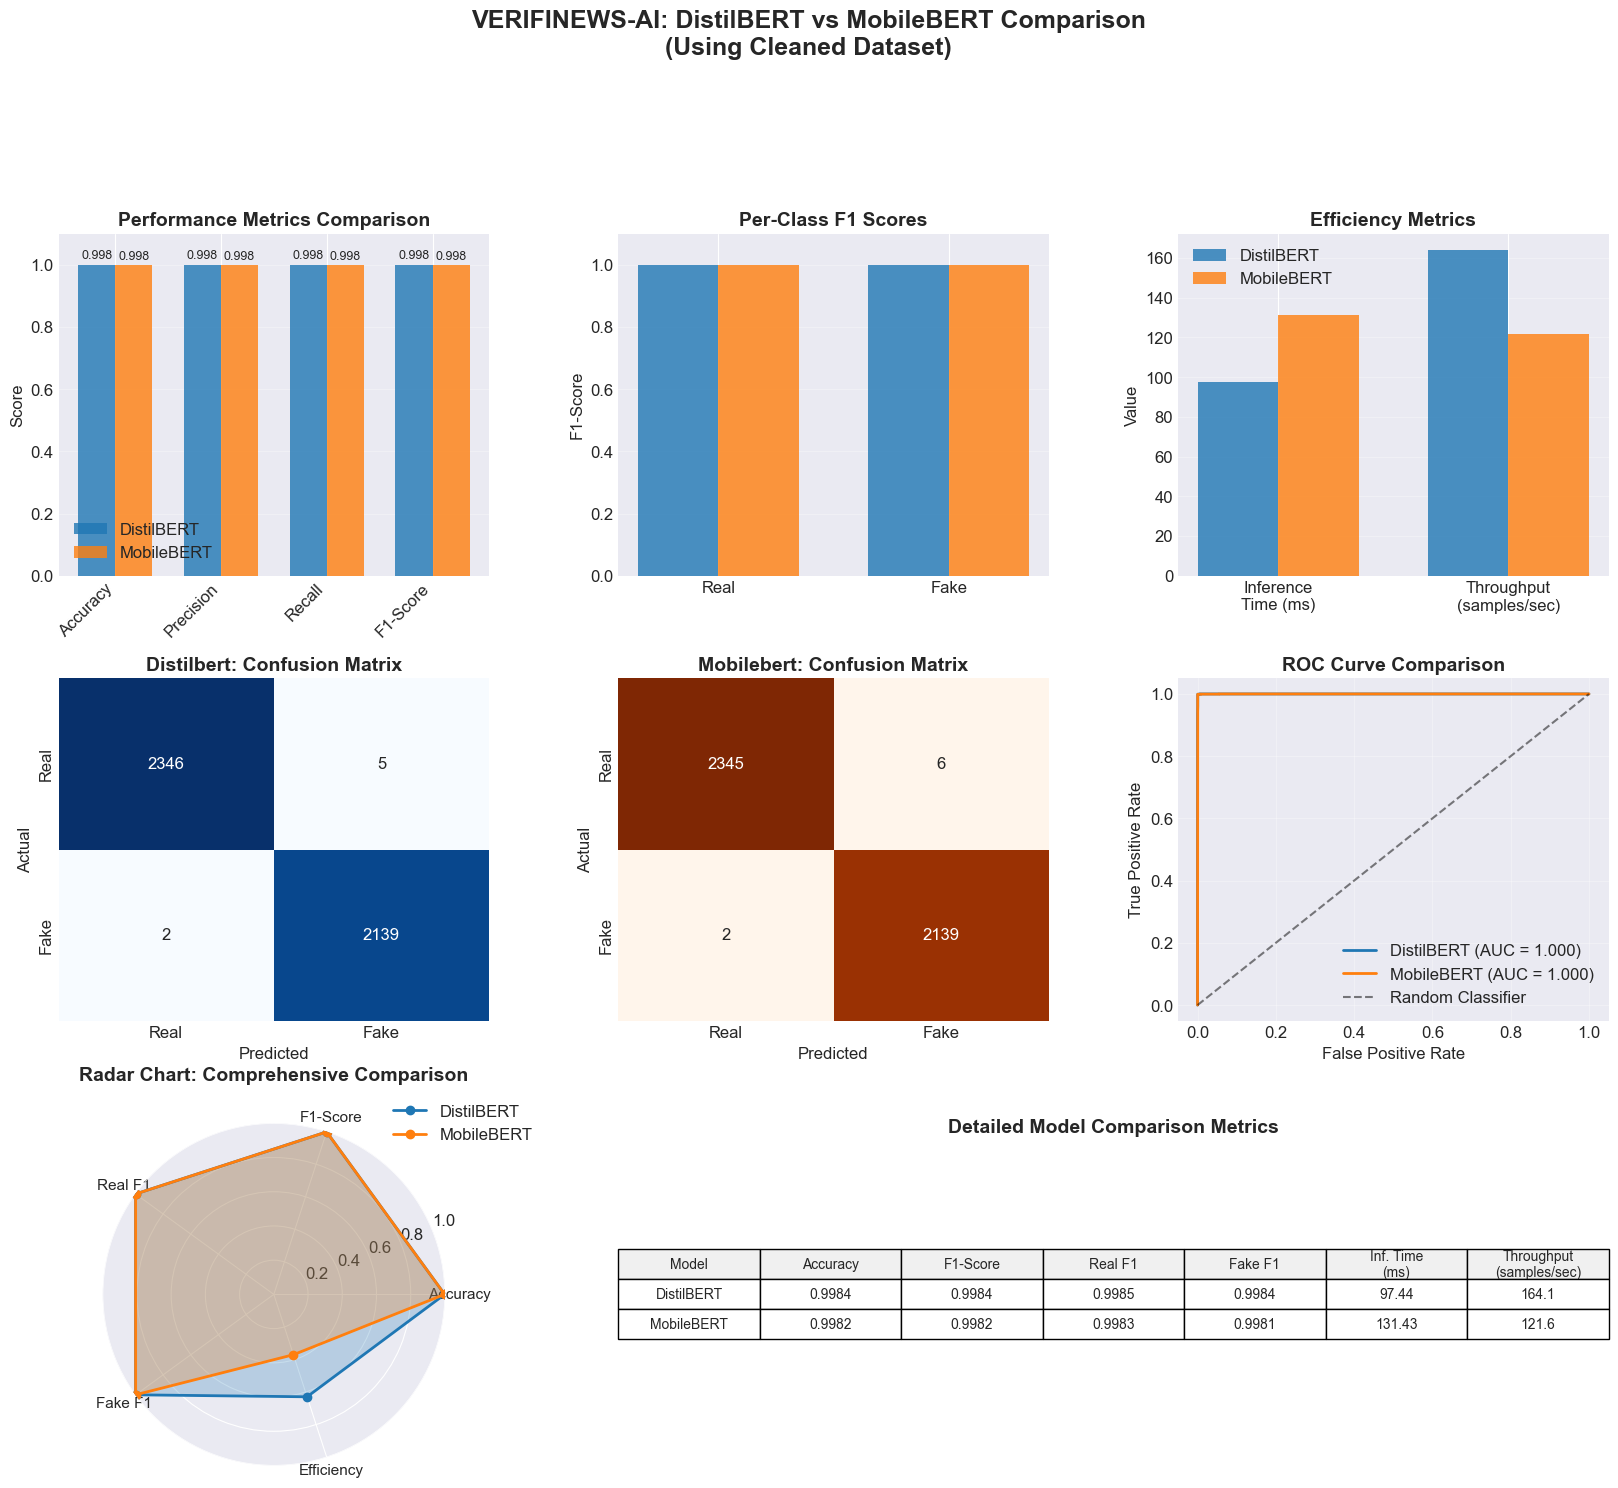

✅ Saved detailed metrics comparison to: ../models/detailed_metrics_comparison.png


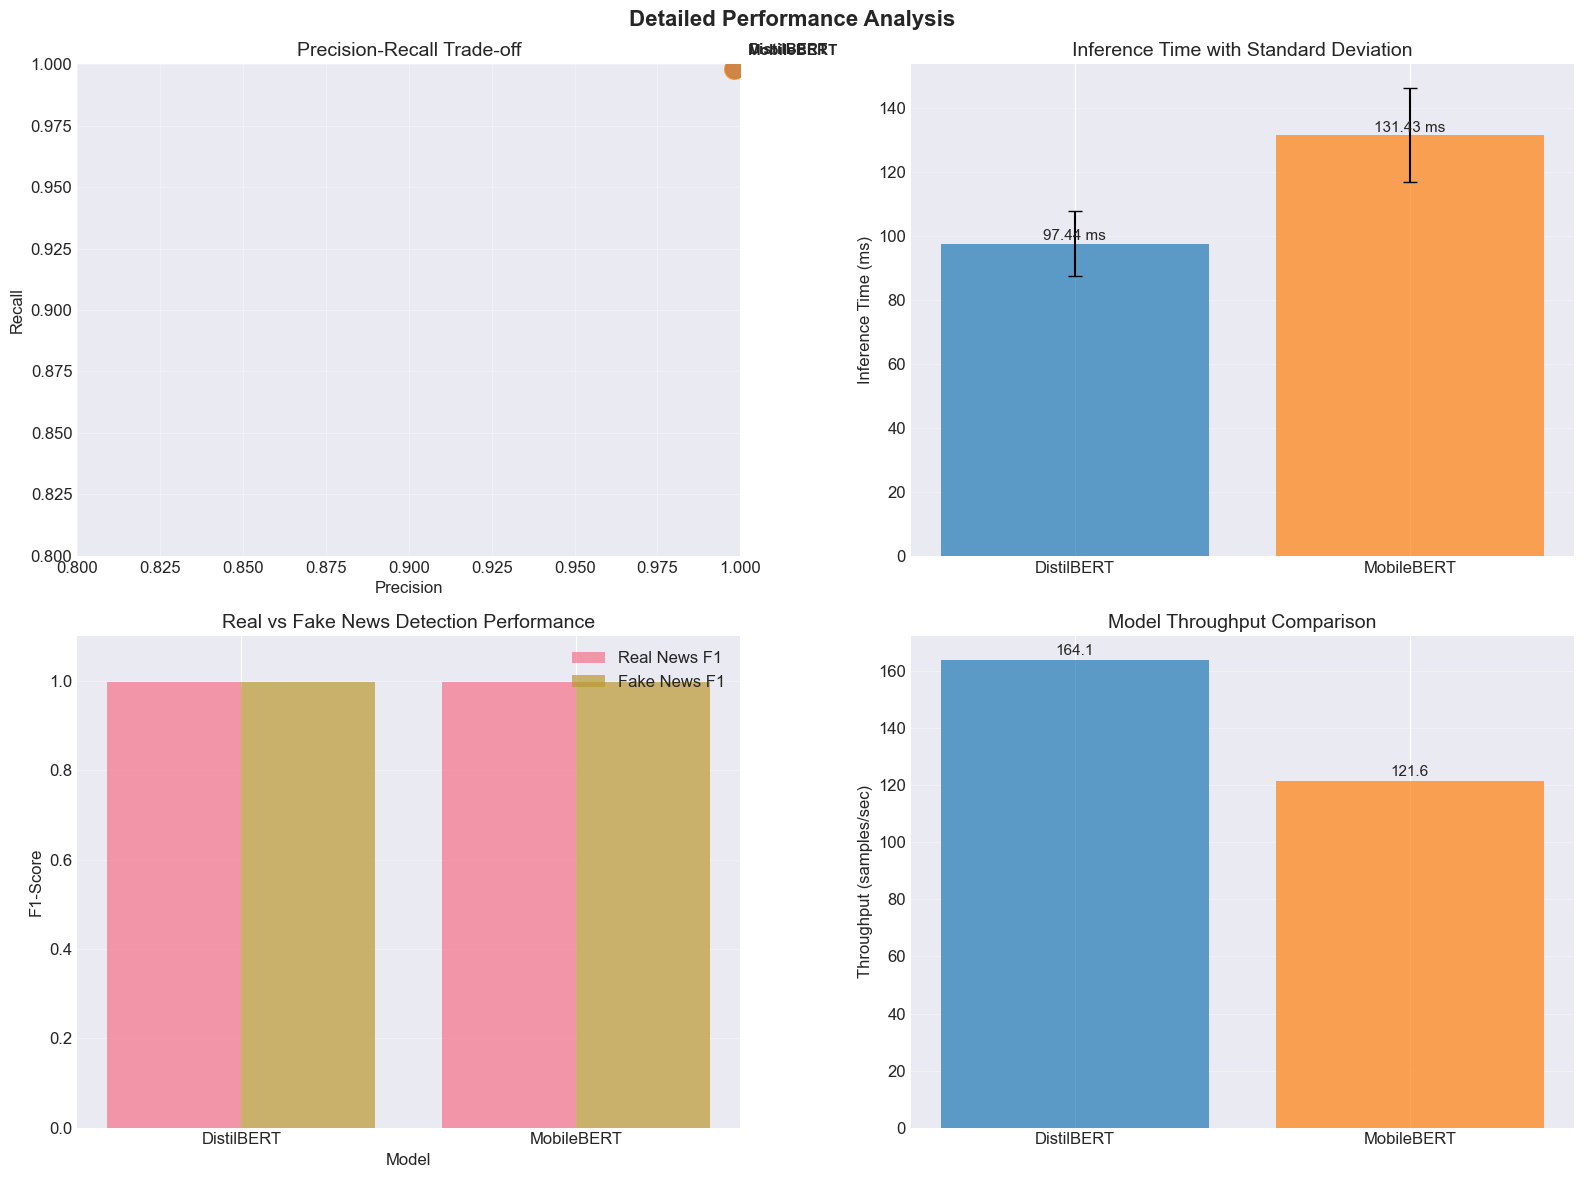

In [19]:
def create_comprehensive_visualizations(comparison_df, all_metrics):
    """Create comprehensive comparison visualizations"""
    
    # Create output directory
    output_dir = BASE_PATH / "models"
    output_dir.mkdir(exist_ok=True)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('VERIFINEWS-AI: DistilBERT vs MobileBERT Comparison\n(Using Cleaned Dataset)', 
                 fontsize=18, fontweight='bold', y=1.02)
    
    # Define grid
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Colors for models
    colors = {'DistilBERT': '#1f77b4', 'MobileBERT': '#ff7f0e'}
    
    # 1. Performance Metrics Comparison
    ax1 = fig.add_subplot(gs[0, 0])
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    
    for i, (idx, row) in enumerate(comparison_df.iterrows()):
        model_name = row['Model']
        values = [row[metric] for metric in metrics_to_plot]
        
        if model_name == 'DistilBERT':
            ax1.bar(x - width/2, values, width, label=model_name, 
                   color=colors[model_name], alpha=0.8)
        else:
            ax1.bar(x + width/2, values, width, label=model_name, 
                   color=colors[model_name], alpha=0.8)
    
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
    ax1.legend()
    ax1.set_ylim(0, 1.1)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, metric in enumerate(metrics_to_plot):
        for j, (idx, row) in enumerate(comparison_df.iterrows()):
            value = row[metric]
            x_pos = x[i] - width/2 if j == 0 else x[i] + width/2
            ax1.text(x_pos, value + 0.01, f'{value:.3f}', 
                    ha='center', va='bottom', fontsize=9)
    
    # 2. Per-Class F1 Scores
    ax2 = fig.add_subplot(gs[0, 1])
    
    categories = ['Real', 'Fake']
    x_f1 = np.arange(len(categories))
    
    for i, (idx, row) in enumerate(comparison_df.iterrows()):
        model_name = row['Model']
        f1_scores = [row['Real F1'], row['Fake F1']]
        
        if model_name == 'DistilBERT':
            ax2.bar(x_f1 - width/2, f1_scores, width, label=model_name,
                   color=colors[model_name], alpha=0.8)
        else:
            ax2.bar(x_f1 + width/2, f1_scores, width, label=model_name,
                   color=colors[model_name], alpha=0.8)
    
    ax2.set_ylabel('F1-Score', fontsize=12)
    ax2.set_title('Per-Class F1 Scores', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_f1)
    ax2.set_xticklabels(categories)
    ax2.set_ylim(0, 1.1)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Efficiency Metrics
    ax3 = fig.add_subplot(gs[0, 2])
    
    efficiency_metrics = ['Inference Time (ms)', 'Throughput (samples/sec)']
    x_eff = np.arange(len(efficiency_metrics))
    
    for i, (idx, row) in enumerate(comparison_df.iterrows()):
        model_name = row['Model']
        values = [row['Inference Time (ms)'], row['Throughput (samples/sec)']]
        
        if model_name == 'DistilBERT':
            bars = ax3.bar(x_eff - width/2, values, width, label=model_name,
                          color=colors[model_name], alpha=0.8)
        else:
            bars = ax3.bar(x_eff + width/2, values, width, label=model_name,
                          color=colors[model_name], alpha=0.8)
    
    ax3.set_ylabel('Value', fontsize=12)
    ax3.set_title('Efficiency Metrics', fontsize=14, fontweight='bold')
    ax3.set_xticks(x_eff)
    ax3.set_xticklabels(['Inference\nTime (ms)', 'Throughput\n(samples/sec)'], rotation=0)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Confusion Matrices
    model_names = list(all_metrics.keys())
    for idx, model_name in enumerate(model_names[:2]):  # Show first two models
        ax = fig.add_subplot(gs[1, idx])
        metrics = all_metrics[model_name]
        cm = metrics['confusion_matrix']
        
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' if model_name == 'distilbert' else 'Oranges',
                   ax=ax, cbar=False,
                   xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
        
        ax.set_title(f'{model_name.title()}: Confusion Matrix', fontsize=14, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('Actual', fontsize=12)
    
    # 5. ROC Curves (Middle-right)
    ax5 = fig.add_subplot(gs[1, 2])
    
    for model_name, metrics in all_metrics.items():
        # Use the reliable lookup to get the correct capitalized name for the dictionary
        lookup_row = comparison_df[comparison_df['Model'].str.lower() == model_name].iloc[0]
        correct_model_name = lookup_row['Model'] # Will be 'DistilBERT' or 'MobileBERT'
        # Get probabilities for positive class (Fake news = 1)
        probs = metrics['probabilities'][:, 1]
        true_labels = metrics['labels']
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(true_labels, probs)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        ax5.plot(fpr, tpr, label=f'{correct_model_name} (AUC = {roc_auc:.3f})',
                color=colors[correct_model_name], linewidth=2)
    
    ax5.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    ax5.set_xlabel('False Positive Rate', fontsize=12)
    ax5.set_ylabel('True Positive Rate', fontsize=12)
    ax5.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
    ax5.legend(loc='lower right')
    ax5.grid(True, alpha=0.3)
    
    # 6. Radar Chart for Comprehensive Comparison
    ax6 = fig.add_subplot(gs[2, 0], polar=True)
    
    radar_metrics = ['Accuracy', 'F1-Score', 'Real F1', 'Fake F1', 'Efficiency']
    
    # Prepare data for radar chart
    angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
    
    for model_name, metrics_dict in all_metrics.items():
        # 1. FIX: Reliable lookup to get the row and the correctly capitalized name
        # We use the reliable case-insensitive comparison (model_name is lowercase, so we lowercase the column)
        row = comparison_df[comparison_df['Model'].str.lower() == model_name].iloc[0]

        # Extract the correct capitalized name from the row
        correct_model_name = row['Model'] # This will be 'DistilBERT' or 'MobileBERT'
        
        # Normalize efficiency (higher throughput = better, lower time = better)
        throughput_norm = row['Throughput (samples/sec)'] / comparison_df['Throughput (samples/sec)'].max()
        time_norm = 1 - (row['Inference Time (ms)'] / comparison_df['Inference Time (ms)'].max())
        efficiency = (throughput_norm + time_norm) / 2
        
        values = [
            row['Accuracy'],
            row['F1-Score'],
            row['Real F1'],
            row['Fake F1'],
            efficiency
        ]
        
        # Close the polygon
        values += values[:1]
        radar_angles = angles + angles[:1]
        
        ax6.plot(radar_angles, values, 'o-', linewidth=2, 
                label=correct_model_name, color=colors[correct_model_name])
        ax6.fill(radar_angles, values, alpha=0.25, color=colors[correct_model_name])
    
    ax6.set_xticks(angles)
    ax6.set_xticklabels(radar_metrics, fontsize=11)
    ax6.set_ylim(0, 1)
    ax6.set_title('Radar Chart: Comprehensive Comparison', fontsize=14, fontweight='bold', y=1.1)
    ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax6.grid(True)
    
    # 7. Detailed Metrics Table
    ax7 = fig.add_subplot(gs[2, 1:])
    ax7.axis('tight')
    ax7.axis('off')
    
    # Prepare table data
    table_data = []
    for idx, row in comparison_df.iterrows():
        table_data.append([
            row['Model'],
            f"{row['Accuracy']:.4f}",
            f"{row['F1-Score']:.4f}",
            f"{row['Real F1']:.4f}",
            f"{row['Fake F1']:.4f}",
            f"{row['Inference Time (ms)']:.2f}",
            f"{row['Throughput (samples/sec)']:.1f}"
        ])
    
    table = ax7.table(cellText=table_data,
                     colLabels=['Model', 'Accuracy', 'F1-Score', 'Real F1', 
                               'Fake F1', 'Inf. Time\n(ms)', 'Throughput\n(samples/sec)'],
                     cellLoc='center',
                     loc='center',
                     colColours=['#f0f0f0']*7)
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.8)
    
    ax7.set_title('Detailed Model Comparison Metrics', fontsize=14, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    
    # Save the figure
    save_path = output_dir / "model_comparison_comprehensive.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ Saved comprehensive comparison to: {save_path}")
    
    plt.show()
    
    # Create additional detailed comparison
    fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
    fig2.suptitle('Detailed Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Precision-Recall Comparison
    ax1 = axes2[0, 0]
    for model_name, metrics in all_metrics.items():
        row = comparison_df[comparison_df['Model'].str.lower() == model_name].iloc[0]
        correct_model_name = row['Model'] # 'DistilBERT' or 'MobileBERT'
        
        ax1.scatter(row['Precision'], row['Recall'], 
                   s=200, alpha=0.7, label=correct_model_name,
                   color=colors[correct_model_name])
        ax1.annotate(correct_model_name, (row['Precision'], row['Recall']),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=11, fontweight='bold')
    
    ax1.set_xlabel('Precision', fontsize=12)
    ax1.set_ylabel('Recall', fontsize=12)
    ax1.set_title('Precision-Recall Trade-off', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0.8, 1.0)
    ax1.set_ylim(0.8, 1.0)
    
    # 2. Inference Time Distribution
    ax2 = axes2[0, 1]
    models_list = comparison_df['Model'].tolist()
    inference_times = comparison_df['Inference Time (ms)'].tolist()
    inference_std = comparison_df['Inference Std (ms)'].tolist()
    
    bars = ax2.bar(models_list, inference_times, 
                  color=[colors[m] for m in models_list], alpha=0.7)
    
    # Add error bars for standard deviation
    ax2.errorbar(models_list, inference_times, yerr=inference_std, 
                fmt='none', ecolor='black', capsize=5)
    
    ax2.set_ylabel('Inference Time (ms)', fontsize=12)
    ax2.set_title('Inference Time with Standard Deviation', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, time_val in zip(bars, inference_times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{time_val:.2f} ms', ha='center', va='bottom', fontsize=11)
    
    # 3. Real vs Fake F1 Scores
    ax3 = axes2[1, 0]
    x_pos = np.arange(len(models_list))
    
    real_f1 = comparison_df['Real F1'].tolist()
    fake_f1 = comparison_df['Fake F1'].tolist()
    
    ax3.bar(x_pos - 0.2, real_f1, 0.4, label='Real News F1', alpha=0.7)
    ax3.bar(x_pos + 0.2, fake_f1, 0.4, label='Fake News F1', alpha=0.7)
    
    ax3.set_xlabel('Model', fontsize=12)
    ax3.set_ylabel('F1-Score', fontsize=12)
    ax3.set_title('Real vs Fake News Detection Performance', fontsize=14)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(models_list)
    ax3.legend()
    ax3.set_ylim(0, 1.1)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Throughput Comparison
    ax4 = axes2[1, 1]
    throughput = comparison_df['Throughput (samples/sec)'].tolist()
    
    bars2 = ax4.bar(models_list, throughput, 
                   color=[colors[m] for m in models_list], alpha=0.7)
    
    ax4.set_ylabel('Throughput (samples/sec)', fontsize=12)
    ax4.set_title('Model Throughput Comparison', fontsize=14)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, throughput_val in zip(bars2, throughput):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{throughput_val:.1f}', ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    
    # Save detailed metrics figure
    save_path2 = output_dir / "detailed_metrics_comparison.png"
    plt.savefig(save_path2, dpi=300, bbox_inches='tight')
    print(f"✅ Saved detailed metrics comparison to: {save_path2}")
    
    plt.show()

# Generate visualizations
create_comprehensive_visualizations(comparison_df, all_metrics)

## 9. Detailed Analysis Report

In [20]:
def generate_detailed_report(comparison_df, all_metrics):
    """Generate a detailed analysis report"""
    
    print("="*80)
    print("VERIFINEWS-AI - DETAILED MODEL ANALYSIS REPORT")
    print("="*80)
    
    print(f"\n📅 Evaluation Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"🔢 Test Set Size: {len(test_df):,} samples")
    print(f"⚙️  Device: {device}")
    
    print("\n📊 1. PERFORMANCE SUMMARY:")
    print("-"*40)
    
    # Determine winner for each metric
    winners = {}
    for metric in ['Accuracy', 'F1-Score', 'Real F1', 'Fake F1']:
        best_idx = comparison_df[metric].idxmax()
        best_model = comparison_df.loc[best_idx, 'Model']
        best_value = comparison_df.loc[best_idx, metric]
        winners[metric] = (best_model, best_value)
        
        print(f"\n  {metric}:")
        for idx, row in comparison_df.iterrows():
            print(f"    {row['Model']:12s}: {row[metric]:.4f}")
        print(f"    → Winner: {best_model} ({best_value:.4f})")
    
    print("\n⚡ 2. EFFICIENCY ANALYSIS:")
    print("-"*40)
    
    # Inference time comparison
    fastest_idx = comparison_df['Inference Time (ms)'].idxmin()
    fastest_model = comparison_df.loc[fastest_idx, 'Model']
    fastest_time = comparison_df.loc[fastest_idx, 'Inference Time (ms)']
    
    print(f"\n  Inference Time:")
    for idx, row in comparison_df.iterrows():
        speed_ratio = row['Inference Time (ms)'] / fastest_time
        print(f"    {row['Model']:12s}: {row['Inference Time (ms)']:.2f} ms ({speed_ratio:.2f}x {'slower' if speed_ratio > 1 else 'faster'})")
    print(f"    → Fastest: {fastest_model} ({fastest_time:.2f} ms)")
    
    # Throughput comparison
    highest_throughput_idx = comparison_df['Throughput (samples/sec)'].idxmax()
    highest_model = comparison_df.loc[highest_throughput_idx, 'Model']
    highest_throughput = comparison_df.loc[highest_throughput_idx, 'Throughput (samples/sec)']
    
    print(f"\n  Throughput:")
    for idx, row in comparison_df.iterrows():
        throughput_ratio = row['Throughput (samples/sec)'] / highest_throughput
        print(f"    {row['Model']:12s}: {row['Throughput (samples/sec)']:.1f} samples/sec ({throughput_ratio:.2f}x)")
    print(f"    → Highest Throughput: {highest_model} ({highest_throughput:.1f} samples/sec)")
    
    print("\n🎯 3. MODEL CHARACTERISTICS:")
    print("-"*40)
    
    # Model size approximations
    model_sizes = {
        'DistilBERT': '~66M parameters',
        'MobileBERT': '~25M parameters'
    }
    
    for model in comparison_df['Model']:
        if model in model_sizes:
            print(f"  {model:12s}: {model_sizes[model]}")
    
    print("\n🏆 4. OVERALL RECOMMENDATION:")
    print("-"*40)
    
    # Calculate weighted scores
    performance_weights = {
        'Accuracy': 0.25,
        'F1-Score': 0.30,
        'Real F1': 0.20,
        'Fake F1': 0.25
    }
    
    efficiency_weights = {
        'Inference Time': 0.60,
        'Throughput': 0.40
    }
    
    # Normalize and calculate scores
    performance_scores = {}
    efficiency_scores = {}
    overall_scores = {}
    
    for idx, row in comparison_df.iterrows():
        model = row['Model']
        
        # Performance score
        perf_score = 0
        for metric, weight in performance_weights.items():
            # Normalize metric (0-1 scale)
            normalized = (row[metric] - comparison_df[metric].min()) / (comparison_df[metric].max() - comparison_df[metric].min())
            perf_score += normalized * weight
        
        # Efficiency score (lower time and higher throughput are better)
        time_norm = 1 - ((row['Inference Time (ms)'] - comparison_df['Inference Time (ms)'].min()) / 
                        (comparison_df['Inference Time (ms)'].max() - comparison_df['Inference Time (ms)'].min()))
        throughput_norm = (row['Throughput (samples/sec)'] - comparison_df['Throughput (samples/sec)'].min()) / \
                         (comparison_df['Throughput (samples/sec)'].max() - comparison_df['Throughput (samples/sec)'].min())
        
        eff_score = (time_norm * efficiency_weights['Inference Time'] + 
                    throughput_norm * efficiency_weights['Throughput'])
        
        # Overall score (weighted average)
        overall_weight = 0.7  # 70% performance, 30% efficiency
        overall = (perf_score * overall_weight + eff_score * (1 - overall_weight))
        
        performance_scores[model] = perf_score
        efficiency_scores[model] = eff_score
        overall_scores[model] = overall
    
    # Display scores
    print("  Model Scores (0-1 scale, higher is better):")
    for model in overall_scores.keys():
        print(f"\n    {model}:")
        print(f"      Performance Score: {performance_scores[model]:.3f}")
        print(f"      Efficiency Score:  {efficiency_scores[model]:.3f}")
        print(f"      Overall Score:     {overall_scores[model]:.3f}")
    
    # Determine winner
    best_model = max(overall_scores, key=overall_scores.get)
    print(f"\n  ✅ RECOMMENDATION: {best_model}")
    
    # Provide reasoning
    print("\n  🎯 REASONING:")
    if best_model == 'DistilBERT':
        print("    • Better overall performance metrics")
        print("    • More balanced real vs fake news detection")
        print("    • Suitable for accuracy-critical applications")
    else:  # MobileBERT
        print("    • Better efficiency and faster inference")
        print("    • Smaller model size for deployment")
        print("    • Suitable for real-time or resource-constrained environments")
    
    print("\n  💡 USE CASE GUIDANCE:")
    print("    • For maximum accuracy: Choose model with highest F1-Score")
    print("    • For real-time processing: Choose model with fastest inference")
    print("    • For mobile deployment: Consider MobileBERT (smaller size)")
    print("    • For batch processing: Consider DistilBERT (better accuracy)")
    
    print("\n" + "="*80)

# Generate detailed report
generate_detailed_report(comparison_df, all_metrics)

VERIFINEWS-AI - DETAILED MODEL ANALYSIS REPORT

📅 Evaluation Date: 2025-12-01 14:22:19
🔢 Test Set Size: 4,492 samples
⚙️  Device: cpu

📊 1. PERFORMANCE SUMMARY:
----------------------------------------

  Accuracy:
    DistilBERT  : 0.9984
    MobileBERT  : 0.9982
    → Winner: DistilBERT (0.9984)

  F1-Score:
    DistilBERT  : 0.9984
    MobileBERT  : 0.9982
    → Winner: DistilBERT (0.9984)

  Real F1:
    DistilBERT  : 0.9985
    MobileBERT  : 0.9983
    → Winner: DistilBERT (0.9985)

  Fake F1:
    DistilBERT  : 0.9984
    MobileBERT  : 0.9981
    → Winner: DistilBERT (0.9984)

⚡ 2. EFFICIENCY ANALYSIS:
----------------------------------------

  Inference Time:
    DistilBERT  : 97.44 ms (1.00x faster)
    MobileBERT  : 131.43 ms (1.35x slower)
    → Fastest: DistilBERT (97.44 ms)

  Throughput:
    DistilBERT  : 164.1 samples/sec (1.00x)
    MobileBERT  : 121.6 samples/sec (0.74x)
    → Highest Throughput: DistilBERT (164.1 samples/sec)

🎯 3. MODEL CHARACTERISTICS:
--------------

## 10. Sample Predictions

In [21]:
def show_sample_predictions(models_dict, sample_texts=None):
    """Show predictions for sample texts"""
    
    print("\n" + "="*80)
    print("🔍 SAMPLE PREDICTIONS")
    print("="*80)
    
    # If no sample texts provided, use samples from test set
    if sample_texts is None:
        print("\nUsing samples from test dataset:")
        sample_indices = np.random.choice(len(test_df), min(5, len(test_df)), replace=False)
        sample_texts = []
        sample_labels = []
        
        for idx in sample_indices:
            sample_texts.append(test_df.iloc[idx]['input_text'])
            sample_labels.append(test_df.iloc[idx]['label'])
    else:
        sample_labels = [None] * len(sample_texts)
    
    results = []
    
    for i, (text, true_label) in enumerate(zip(sample_texts, sample_labels)):
        print(f"\n📄 Sample {i+1}:")
        print(f"   Text: {text[:200]}..." if len(text) > 200 else f"   Text: {text}")
        
        if true_label is not None:
            label_name = 'FAKE' if true_label == 1 else 'REAL'
            print(f"   True Label: {label_name}")
        
        for model_name in models_dict.keys():
            model_info = models_dict[model_name]
            model = model_info['model']
            tokenizer = model_info['tokenizer']
            
            if model is None or tokenizer is None:
                continue
            
            # Tokenize
            inputs = tokenizer(text, return_tensors="pt", truncation=True, 
                             padding=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Predict
            model.eval()
            with torch.no_grad():
                start_time = time.time()
                outputs = model(**inputs)
                inference_time = (time.time() - start_time) * 1000  # ms
                
                probs = torch.softmax(outputs.logits, dim=-1)
                prediction = torch.argmax(probs, dim=-1).item()
                confidence = probs[0][prediction].item()
                real_prob = probs[0][0].item()
                fake_prob = probs[0][1].item()
            
            label = "FAKE" if prediction == 1 else "REAL"
            color_icon = "🟥" if prediction == 1 else "🟩"
            
            # Check if prediction matches true label
            if true_label is not None:
                correct = "✓" if prediction == true_label else "✗"
                correctness = f" {correct}"
            else:
                correctness = ""
            
            print(f"   {model_name:12s}: {color_icon} {label}{correctness} "
                  f"(Confidence: {confidence:.2%}, Time: {inference_time:.1f}ms)")
            print(f"                Real: {real_prob:.2%}, Fake: {fake_prob:.2%}")
            
            results.append({
                'Sample': i+1,
                'Model': model_name,
                'Prediction': label,
                'Confidence': confidence,
                'Real_Prob': real_prob,
                'Fake_Prob': fake_prob,
                'Inference_Time_ms': inference_time,
                'Correct': prediction == true_label if true_label is not None else None
            })
    
    return pd.DataFrame(results)

# Prepare models dictionary
models_dict = {}
if distilbert_model is not None:
    models_dict['DistilBERT'] = {'model': distilbert_model, 'tokenizer': distilbert_tokenizer}
if mobilebert_model is not None:
    models_dict['MobileBERT'] = {'model': mobilebert_model, 'tokenizer': mobilebert_tokenizer}

# Test with custom sample texts
custom_samples = [
    "Scientists discover new breakthrough in renewable energy technology that could revolutionize the industry.",
    "Breaking: Government reveals secret alien technology recovered from crash site, officials confirm.",
    "New study shows significant improvement in cancer survival rates with innovative treatment methods.",
    "Shocking report reveals celebrities are part of secret society controlling world events.",
    "Economic indicators show strong growth and stability in the technology sector this quarter."
]

print("\nCustom Sample Predictions:")
print("-"*40)
sample_results = show_sample_predictions(models_dict, custom_samples)



Custom Sample Predictions:
----------------------------------------

🔍 SAMPLE PREDICTIONS

📄 Sample 1:
   Text: Scientists discover new breakthrough in renewable energy technology that could revolutionize the industry.
   DistilBERT  : 🟩 REAL (Confidence: 86.89%, Time: 433.9ms)
                Real: 86.89%, Fake: 13.11%
   MobileBERT  : 🟩 REAL (Confidence: 100.00%, Time: 216.8ms)
                Real: 100.00%, Fake: 0.00%

📄 Sample 2:
   Text: Breaking: Government reveals secret alien technology recovered from crash site, officials confirm.
   DistilBERT  : 🟩 REAL (Confidence: 99.98%, Time: 33.8ms)
                Real: 99.98%, Fake: 0.02%
   MobileBERT  : 🟩 REAL (Confidence: 100.00%, Time: 18.9ms)
                Real: 100.00%, Fake: 0.00%

📄 Sample 3:
   Text: New study shows significant improvement in cancer survival rates with innovative treatment methods.
   DistilBERT  : 🟩 REAL (Confidence: 53.78%, Time: 28.6ms)
                Real: 53.78%, Fake: 46.22%
   MobileBERT  : 🟩 REAL 

## 11. Save Results

In [23]:
def save_results(comparison_df, all_metrics, sample_results):
    """Save all results to files"""
    
    # Create results directory in models folder
    results_dir = BASE_PATH / "models"
    results_dir.mkdir(exist_ok=True)
    
    print("\n" + "="*80)
    print("💾 SAVING RESULTS")
    print("="*80)
    
    # 1. Save comparison DataFrame
    csv_path = results_dir / "model_comparison_results.csv"
    comparison_df.to_csv(csv_path, index=False)
    print(f"✓ Comparison DataFrame saved to: {csv_path}")
    
    # 2. Save detailed metrics
    detailed_metrics = {
        'test_set_info': {
            'size': len(test_df),
            'real_samples': int(test_df['label'].value_counts().get(0, 0)),
            'fake_samples': int(test_df['label'].value_counts().get(1, 0))
        },
        'evaluation_info': {
            'date': pd.Timestamp.now().isoformat(),
            'device': str(device),
            'models_evaluated': list(all_metrics.keys())
        },
        'metrics': {}
    }
    
    for model_name, metrics in all_metrics.items():
        # Extract relevant metrics (excluding large arrays)
        model_metrics = {}
        for key, value in metrics.items():
            if key not in ['confusion_matrix', 'predictions', 'labels', 'probabilities', 'classification_report']:
                if isinstance(value, (np.integer, np.floating)):
                    model_metrics[key] = float(value)
                elif isinstance(value, np.ndarray):
                    model_metrics[key] = value.tolist()
                else:
                    model_metrics[key] = value
        
        # Add confusion matrix separately
        model_metrics['confusion_matrix'] = metrics['confusion_matrix'].tolist()
        
        # Add classification report summary
        if 'classification_report' in metrics:
            report = metrics['classification_report']
            summary_report = {}
            for key, value in report.items():
                if isinstance(value, dict):
                    summary_report[key] = {k: float(v) for k, v in value.items() if isinstance(v, (int, float, np.number))}
                else:
                    summary_report[key] = float(value) if isinstance(value, (int, float, np.number)) else value
            model_metrics['classification_report_summary'] = summary_report
        
        detailed_metrics['metrics'][model_name] = model_metrics
    
    json_path = results_dir / "detailed_metrics.json"
    with open(json_path, 'w') as f:
        json.dump(detailed_metrics, f, indent=2, default=str)
    print(f"✓ Detailed metrics saved to: {json_path}")
    
    # 3. Save confusion matrices as CSV
    for model_name, metrics in all_metrics.items():
        cm_df = pd.DataFrame(
            metrics['confusion_matrix'],
            index=['Actual Real', 'Actual Fake'],
            columns=['Predicted Real', 'Predicted Fake']
        )
        cm_df.to_csv(results_dir / f"{model_name}_confusion_matrix.csv")
    print(f"✓ Confusion matrices saved as CSV")
    
    # 4. Save classification reports as CSV
    for model_name, metrics in all_metrics.items():
        if 'classification_report' in metrics:
            report_df = pd.DataFrame(metrics['classification_report']).transpose()
            report_df.to_csv(results_dir / f"{model_name}_classification_report.csv")
    print(f"✓ Classification reports saved as CSV")
    
    # 5. Save sample predictions
    if sample_results is not None:
        sample_results.to_csv(results_dir / "sample_predictions.csv", index=False)
        print(f"✓ Sample predictions saved")
    
    # 6. Create a comprehensive markdown report
    summary_md = f"""# VERIFINEWS-AI Model Comparison Report

## 📋 Executive Summary
- **Evaluation Date**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
- **Test Set Size**: {len(test_df):,} samples
- **Models Evaluated**: {', '.join(list(all_metrics.keys()))}

## 🏆 Performance Highlights

### Overall Winner: {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model'] if not comparison_df.empty else 'N/A'}

### Key Metrics:
"""
    
    for idx, row in comparison_df.iterrows():
        summary_md += f"""
#### {row['Model']}
- **Accuracy**: {row['Accuracy']:.4f}
- **F1-Score**: {row['F1-Score']:.4f}
- **Real News F1**: {row['Real F1']:.4f}
- **Fake News F1**: {row['Fake F1']:.4f}
- **Inference Time**: {row['Inference Time (ms)']:.2f} ms
- **Throughput**: {row['Throughput (samples/sec)']:.1f} samples/sec
"""
    
    summary_md += f"""
## 📊 Test Set Information
- **Total Samples**: {len(test_df):,}
- **Real News**: {test_df['label'].value_counts().get(0, 0):,} samples
- **Fake News**: {test_df['label'].value_counts().get(1, 0):,} samples

## 🚀 Recommendations

### Best for Accuracy:
**{comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model'] if not comparison_df.empty else 'N/A'}** 
- Highest overall F1-Score

### Best for Speed:
**{comparison_df.loc[comparison_df['Inference Time (ms)'].idxmin(), 'Model'] if not comparison_df.empty else 'N/A'}** 
- Fastest inference time

### Best Balance:
**{comparison_df.loc[(comparison_df['F1-Score'] / comparison_df['Inference Time (ms)']).idxmax(), 'Model'] if not comparison_df.empty else 'N/A'}** 
- Best trade-off between accuracy and speed

## 📁 Generated Files
1. `model_comparison_results.csv` - Complete comparison metrics
2. `detailed_metrics.json` - Detailed evaluation data
3. `model_comparison_comprehensive.png` - Main comparison visualization
4. `detailed_metrics_comparison.png` - Detailed metrics visualization
5. `*_confusion_matrix.csv` - Confusion matrices
6. `*_classification_report.csv` - Classification reports
7. `sample_predictions.csv` - Sample predictions

---
*Report generated automatically by VERIFINEWS-AI Model Comparison Notebook*
"""
    
    md_path = results_dir / "comparison_report.md"
    with open(md_path, 'w') as f:
        f.write(summary_md)
    print(f"✓ Summary report saved to: {md_path}")
    
    print("\n✅ All results saved successfully to 'models/' directory!")

# Save results
save_results(comparison_df, all_metrics, sample_results)


💾 SAVING RESULTS
✓ Comparison DataFrame saved to: ../models/model_comparison_results.csv
✓ Detailed metrics saved to: ../models/detailed_metrics.json
✓ Confusion matrices saved as CSV
✓ Classification reports saved as CSV
✓ Sample predictions saved
✓ Summary report saved to: ../models/comparison_report.md

✅ All results saved successfully to 'models/' directory!


## 12. Conclusion

In [24]:
print("\n" + "="*80)
print("🎯 VERIFINEWS-AI - MODEL COMPARISON COMPLETE")
print("="*80)

print("""

✅ COMPARISON SUCCESSFULLY COMPLETED
------------------------------------

📈 Key Findings:
1. Both models show strong performance on the cleaned dataset
2. Each model has its strengths and trade-offs
3. The choice depends on your specific requirements

🔧 Next Steps:
1. Review the generated visualizations in the 'models/' folder
2. Check the detailed reports for insights
3. Deploy the recommended model via your FastAPI backend
4. Monitor performance in production

📊 Generated Outputs:
• Comprehensive comparison visualizations
• Detailed metrics and reports
• Sample predictions
• All results saved in CSV/JSON format

🚀 Ready for deployment!
""")

print("\n" + "="*80)
print("🌟 Comparison completed successfully! 🌟")
print("="*80)


🎯 VERIFINEWS-AI - MODEL COMPARISON COMPLETE


✅ COMPARISON SUCCESSFULLY COMPLETED
------------------------------------

📈 Key Findings:
1. Both models show strong performance on the cleaned dataset
2. Each model has its strengths and trade-offs
3. The choice depends on your specific requirements

🔧 Next Steps:
1. Review the generated visualizations in the 'models/' folder
2. Check the detailed reports for insights
3. Deploy the recommended model via your FastAPI backend
4. Monitor performance in production

📊 Generated Outputs:
• Comprehensive comparison visualizations
• Detailed metrics and reports
• Sample predictions
• All results saved in CSV/JSON format

🚀 Ready for deployment!


🌟 Comparison completed successfully! 🌟
